# WeRateDogs Tweets analysis project

In [2]:
# Importing needed libararies
import numpy as np
import pandas as pd
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Gathering Date

In [3]:
# reding twitter archive enhanced file
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# downloding and reading Image Predictions file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name=url.split('/')[-1]
url_data=requests.get(url)

if not os.path.isfile(file_name):
    with open(file_name,'wb') as file:
        file.write(url_data.content)
        
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
# Reading Twitter API into dataframe

df_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count})
        
twitter_api_df = pd.DataFrame(df_list)


Assessing the Data for Quality & Tidiness issues

In [6]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
twitter_archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [9]:
twitter_archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [36]:
twitter_archive_df.name.value_counts()

None          745
a              55
Charlie        12
Oliver         11
Cooper         11
Lucy           11
Tucker         10
Lola           10
Penny          10
Bo              9
Winston         9
the             8
Sadie           8
Bailey          7
Daisy           7
Toby            7
an              7
Buddy           7
Jax             6
Jack            6
Milo            6
Bella           6
Stanley         6
Leo             6
Dave            6
Koda            6
Oscar           6
Rusty           6
Scout           6
Phil            5
             ... 
Finnegus        1
Wiggles         1
Joey            1
Vinscent        1
Pluto           1
Durg            1
Lizzie          1
Livvie          1
Kallie          1
Brandonald      1
Grizzie         1
Kevon           1
Smiley          1
Storkson        1
Nico            1
Bloo            1
Raphael         1
Chef            1
Willem          1
Jareld          1
Karma           1
Blanket         1
Batdog          1
Ace             1
Brian     

In [11]:
twitter_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
user_count        2354 non-null int64
dtypes: int64(4)
memory usage: 73.6 KB


In [12]:
twitter_api_df.head()

,favorite_count,retweet_count,tweet_id,user_count
0,39467,8853,892420643555336193,3200889
1,33819,6514,892177421306343426,3200889
2,25461,4328,891815181378084864,3200889
3,42908,8964,891689557279858688,3200889
4,41048,9774,891327558926688256,3200889


In [13]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


summary of Quality & Tidiness issues:

Quality Issues:-
- missing data in twitter archive data in columns expanded_urls & in_reply_to_status_id & in_reply_to_user_id & retweeted_status_id & retweeted_status_user_id & retweeted_status_timestamp
- missing inforamtion represanted as 'None' instead of empty cells(NaN) in twitter archive data in name, doggo, floofer, pupper, puppo columns
- tweet_id dtype need to be object not int64.
- timestamp dtype need to be datetime not object.
- twitter archive data include retweets that need to be removed.
- twitter archive data include replies that need to be removed.
- twitter archive data include tweets without photos that need to be removed.
- Incorrect figuers extraction in rating_numerator and rating_denominator e.g Zero is not avalid denominator.
- missy and un-useful data to be deleted e.g source cloumn.

Tidiness Issues:-
- Dog stage separated into four cloumns which is need to be merged in one cloumn.
- related data for same tweeets separated in different tables as twitter_archive_df and twitter_api_df witch is need to be merged in one dataset.

Cleaning the Data

In [15]:
#copying tables fro cleaning
twitter_archive_clean = twitter_archive_df.copy()
twitter_api_clean = twitter_api_df.copy()
image_predictions_clean = image_predictions_df.copy()

In [16]:
# removing retweets and replies
replies = twitter_archive_clean[twitter_archive_clean['in_reply_to_status_id'].notnull()].index
twitter_archive_clean.drop(index=replies,inplace=True)

retweets = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].notnull()].index
twitter_archive_clean.drop(index=retweets,inplace=True)

In [17]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [18]:
#remove not needed cloumns
twitter_archive_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'source','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls'], inplace=True)

In [19]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(7)
memory usage: 180.2+ KB


In [20]:
#change datatypes
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype('str')
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
twitter_api_clean['tweet_id'] = twitter_api_clean['tweet_id'].astype('str')
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype('str')

In [21]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 180.2+ KB


In [22]:
# Cleaning and Merging Dog stages in one cloumn
twitter_archive_clean.iloc[:, -4:  ] = twitter_archive_clean.iloc[:, -4:  ].replace('None','')

twitter_archive_clean['Dog_Stages'] = twitter_archive_clean['doggo'] +twitter_archive_clean['floofer'] +twitter_archive_clean['pupper'] +twitter_archive_clean['puppo']  

twitter_archive_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace =True)


In [23]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 7 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
Dog_Stages            2097 non-null object
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 131.1+ KB


In [24]:
twitter_archive_clean.Dog_Stages.value_counts()

                1761
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggopuppo         1
doggofloofer       1
Name: Dog_Stages, dtype: int64

In [25]:
twitter_archive_clean.Dog_Stages =twitter_archive_clean.Dog_Stages.replace('doggopupper' ,'doggo-pupper')
twitter_archive_clean.Dog_Stages =twitter_archive_clean.Dog_Stages.replace('doggopuppo' ,'doggo-puppo')
twitter_archive_clean.Dog_Stages =twitter_archive_clean.Dog_Stages.replace('doggofloofer' ,'doggo-floofer')



In [26]:
twitter_archive_clean.Dog_Stages.value_counts()

                 1761
pupper            221
doggo              72
puppo              23
floofer             9
doggo-pupper        9
doggo-puppo         1
doggo-floofer       1
Name: Dog_Stages, dtype: int64

In [27]:
# removing tweets not include pictures form archive
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.tweet_id.isin(image_predictions_clean.tweet_id)]

# removing retweets and replies from image predictions
image_predictions_clean = image_predictions_clean[image_predictions_clean.tweet_id.isin(twitter_archive_clean.tweet_id)]



In [28]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 7 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
Dog_Stages            1971 non-null object
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 123.2+ KB


In [29]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1971 non-null object
jpg_url     1971 non-null object
img_num     1971 non-null int64
p1          1971 non-null object
p1_conf     1971 non-null float64
p1_dog      1971 non-null bool
p2          1971 non-null object
p2_conf     1971 non-null float64
p2_dog      1971 non-null bool
p3          1971 non-null object
p3_conf     1971 non-null float64
p3_dog      1971 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 159.8+ KB


In [30]:
#Merging twitter archive and twitter api data into one dataframe
twitter_archive_final = twitter_archive_clean.merge(twitter_api_clean, how='inner', on='tweet_id')

In [31]:
twitter_archive_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 10 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
Dog_Stages            1971 non-null object
favorite_count        1971 non-null int64
retweet_count         1971 non-null int64
user_count            1971 non-null int64
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 169.4+ KB


In [32]:
#Storing final dataset
twitter_archive_final.to_csv('Twitter_archive_final.csv',index=False)

Analyze & Visualize

In [33]:
# Tweets Analysis
twitter_archive_final.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,user_count
count,1971.000000,1971.000000,1971.000000,1971.000000,1.971000e+03
mean,12.223237,10.477423,8949.106545,2784.449518,3.200946e+06
std,41.634034,6.853275,12267.799790,4697.662893,4.483418e+01
min,0.000000,2.000000,81.000000,16.000000,3.200799e+06
25%,10.000000,10.000000,1997.000000,628.500000,3.200901e+06
50%,11.000000,10.000000,4147.000000,1367.000000,3.200947e+06
75%,12.000000,10.000000,11402.500000,3239.000000,3.201002e+06
max,1776.000000,170.000000,132810.000000,79515.000000,3.201018e+06


In [34]:
twitter_archive_final.corr()

,rating_numerator,rating_denominator,favorite_count,retweet_count,user_count
rating_numerator,1.000000,0.185722,0.010876,0.014664,-0.021714
rating_denominator,0.185722,1.000000,-0.025708,-0.018270,0.001846
favorite_count,0.010876,-0.025708,1.000000,0.913014,-0.548960
retweet_count,0.014664,-0.018270,0.913014,1.000000,-0.365683
user_count,-0.021714,0.001846,-0.548960,-0.365683,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f449b6d97f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f44993d1860>]], dtype=object)

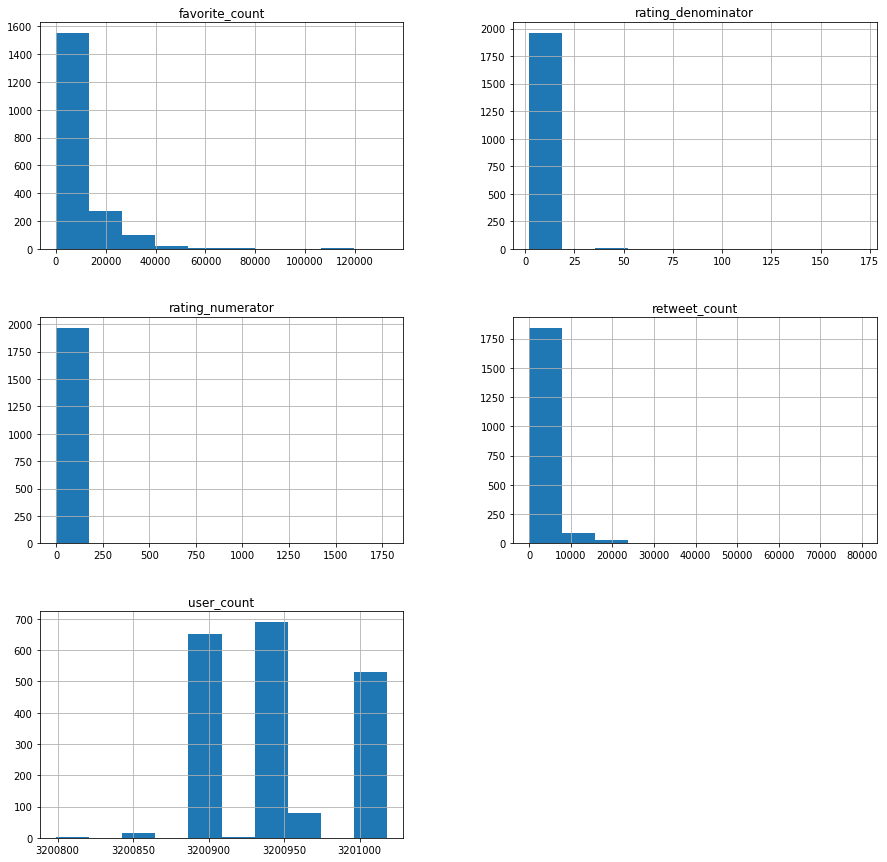

In [35]:
twitter_archive_final.hist(figsize=(15,15))